In [1]:
import numpy as np
import operator
import logging
import time
from functools import partial

import torch
import tqdm

from pycbc.waveform import get_fd_waveform

In [2]:
data = {"L1": np.load("/users/sgreen/gwtuna/LVK/Paper/BBHSearch/P.E./L1_data.npy")}#, "H1": jnp.load("H1_data.npy")}
freqs = np.load("/users/sgreen/gwtuna/LVK/Paper/BBHSearch/P.E./L1_freqs.npy")
psd = {"L1": np.load("/users/sgreen/gwtuna/LVK/Paper/BBHSearch/P.E./L1_psd.npy")}#, "H1": jnp.load("H1_psd.npy")}

In [3]:
data = data['L1']
psd = psd['L1']
print(freqs)

[0.00000e+00 2.50000e-01 5.00000e-01 ... 2.04750e+03 2.04775e+03
 2.04800e+03]


In [10]:
class PE:
    def __init__(self, data, psd, freqs):
        self.data = data
        self.psd = psd
        self.freqs = freqs
        
    def log_prior(self, params):
        m1, m2 = params
        if 3.0 < m1 < 100 and 3.0 < m2 < 100.0:
            return 0.0
        return -np.inf
        
    def log_likelihood(self, params):
        m1, m2 = params
        hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=m1, mass2=m2, delta_f=0.25, f_lower=20.0, f_final=2048)
        d_inner_h = 0.
        optimal_snr_squared = 0.
        fp = -0.456852978678261
        fc = 0.36204310587763466
        h = hp*fp + hc*fc
        h_star = np.conj(h)
        integrand = np.nan_to_num(h_star * data / psd, 0.)
        d_inner_h += 4.0 / 32.0 * np.sum(integrand)
        integrand = np.nan_to_num(h_star * h / psd, 0.)
        optimal_snr_squared += (4.0 / 32.0 * np.sum(integrand)).real
        log_l = d_inner_h.real - optimal_snr_squared / 2
        return log_l.real
    
    def log_probability(self, params):
        lp = self.log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(params)

In [11]:
parameter_est = PE(data, psd, freqs)
parameter_est.log_prior(params = [0, 0])

-inf

In [5]:
class SGHMC:
    
    def __init__(self, params, alpha, eta, log_density):
        """
        Stochastic Gradient Monte Carlo sampler WITH momentum
        This is Hamiltonian Monte Carlo.
        
        Paramters
        ---------
        alpha: momentum param
        eta: learning rate
        log_density: loss function for given sample/batch of data
        """
        self.alpha = alpha
        self.eta = eta
        self.log_density = log_density
        self.optimizer = torch.optim.SGD(params, lr=1, momentum=(1 - self.alpha))
    
    def _noise(self, params):
        std = np.sqrt(2 * self.alpha * self.eta)
        loss = 0.
        for param in params:
            noise = torch.randn_like(param) * std
            loss += (noise * param).sum()
        return loss
        
    def sample(self, params):
        self.optimizer.zero_grad()
        loss = self.log_density(params) * self.eta
        loss += self._noise(params)
        loss.backward()
        self.optimizer.step()
        return params


In [6]:
class SGLD:
    
    def __init__(self, params, eta, log_density):
        """
        Stochastic gradilog_densityent monte carlo sampler via Langevin Dynamics            
        Parameters
        ----------
        eta: float
            learning rate param
        log_density: function computing log_density (loss) for given sample and batch of data.
        """
        self.eta = eta
        self.log_density = log_density
        self.optimizer = torch.optim.SGD(params, lr=1, momentum=0.)  # momentum is set to zero
    
    def _noise(self, params): 
        """We are adding param+noise to each param."""
        std = np.sqrt(2 * self.eta)
        loss = 0.
        for param in params:
            noise = torch.randn_like(param) * std
            loss += (noise * param).sum()
        return loss
        
    def sample(self, params):
        self.optimizer.zero_grad()
        loss = self.log_density(params) * self.eta
        loss += self._noise(params)  # add noise*param before calling backward!
        loss.backward()  # let autograd do its thing
        self.optimizer.step()
        return params

In [7]:
dist = PE(data, psd, freqs)

In [8]:
x = torch.tensor([30.0, 30.0], requires_grad=True)
sghmc = SGHMC([x], eta=1e-4, alpha=0.001, log_density=dist.log_probability)

In [9]:
samples = []

for epoch in tqdm.tqdm(range(10000)):
    x = sghmc.sample(x)
    samples.append(x.detach().clone().T)
        
samples = np.vstack(samples)

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_27675/1733397371.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  samples.append(x.detach().clone().T)
100%|██████████| 10000/10000 [00:51<00:00, 194.18it/s]


In [10]:
m1 = []
m2 = []
for x in samples: 
    m1.append(x[0])
    m2.append(x[1])

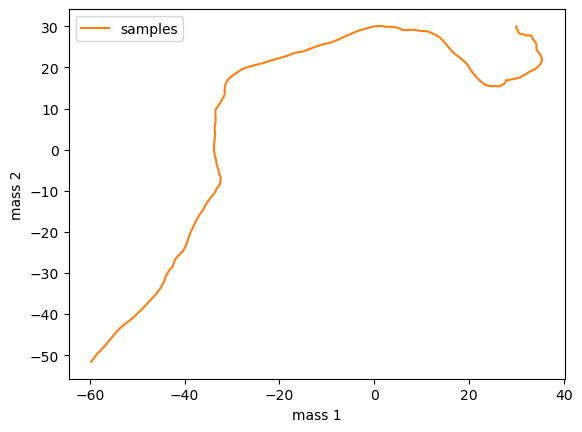

In [11]:
from matplotlib import pyplot as plt
plt.plot(m1, m2, "C1-", label='samples')
plt.xlabel('mass 1')
plt.ylabel('mass 2')
plt.legend()

In [12]:
x = torch.tensor([30.0, 30.0], requires_grad=True)
sgld = SGLD([x], eta=1e-1, log_density=dist.log_probability)

In [13]:
samples = []

for epoch in tqdm.tqdm(range(10000)):
    x = sgld.sample(x)
    samples.append(x.data.clone().detach().T)
        
samples = np.vstack(samples)

100%|██████████| 10000/10000 [01:33<00:00, 107.31it/s]


In [14]:
m1 = []
m2 = []
for x in samples: 
    m1.append(x[0])
    m2.append(x[1])

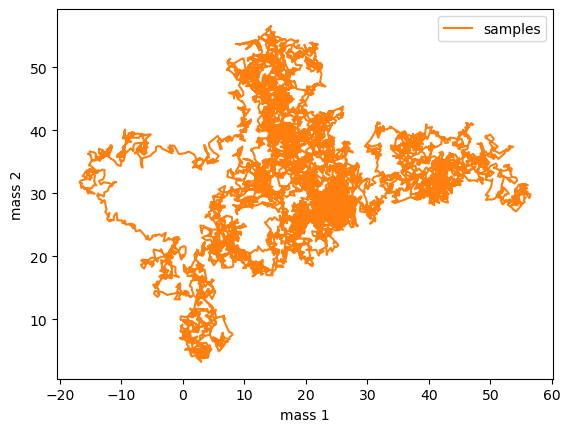

In [15]:
from matplotlib import pyplot as plt
plt.plot(m1, m2, "C1-", label='samples')
plt.xlabel('mass 1')
plt.ylabel('mass 2')
plt.legend()